# Assignment 2
## Forecasting Power Consumption of house with LTSM deep Neural Network 
### Dataset : Heat and Power consumption of residential building
This Dataset contains series of data from december 2010 to november 2018 with one hour time step, containing 70,080 measurements. It include mutliple variables like air pressure,temperature,humidity,wind speed etc.

## Step 1 Imports

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
from math import sqrt
from numpy import concatenate
from pandas import concat
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold,cross_val_score
from keras.models import Sequential
from keras.layers import Dense , Dropout
from keras.layers import LSTM , LeakyReLU


In [145]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024*6)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

Virtual devices cannot be modified after being initialized


In [146]:
tf.debugging.set_log_device_placement(True)

## Step 2 load Data

In [147]:
data = pd.read_csv("Load_data_new.csv", index_col=0)
data.index.name = 'datetime'
data.head()

,air_pressure[mmHg],air_temperature[degree celcius],relative_humidity[%],wind_speed[M/S],solar_irridiation[W/m²],total_cloud_cover[from ten],electricity_demand_values[kw],heat_demand_values[kw]
datetime,,,,,,,,
2010-12-01 00:00:00,729.7,25.0,85.0,5.0,0,no clouds,289.567557,432.940036
2010-12-01 01:00:00,729.4,27.8,77.0,7.0,0,no clouds,260.168520,473.935901
2010-12-01 02:00:00,728.9,33.3,62.0,7.0,0,2/10–3/10.,247.273585,483.278761
2010-12-01 03:00:00,731.6,32.2,62.0,2.0,0,5/10.,257.955878,545.921252
2010-12-01 04:00:00,732.6,22.8,96.0,3.0,0,2/10–3/10.,258.255081,550.526112


In [148]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70080 entries, 2010-12-01 00:00:00 to 2018-11-28 23:00:00
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   air_pressure[mmHg]               69934 non-null  float64
 1   air_temperature[degree celcius]  69903 non-null  float64
 2   relative_humidity[%]             69903 non-null  float64
 3   wind_speed[M/S]                  69125 non-null  float64
 4   solar_irridiation[W/m²]          70080 non-null  int64  
 5   total_cloud_cover[from ten]      69837 non-null  object 
 6   electricity_demand_values[kw]    70073 non-null  float64
 7   heat_demand_values[kw]           70073 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 4.8+ MB


## Step 3 Data Cleaning

As we can see from above some columns names have space between them, we will replace with new names, to make columns names consistant 

In [149]:
data2 = data.copy();
data2.columns = ['air_pressure','air_temperature','relative_humidity','wind_speed','solar_irridiation','total_cloud_cover','electricity_demand_values','heat_demand_values']
data2.columns

Index(['air_pressure', 'air_temperature', 'relative_humidity', 'wind_speed',
       'solar_irridiation', 'total_cloud_cover', 'electricity_demand_values',
       'heat_demand_values'],
      dtype='object')

#### All other column data is numerical except time and total_cloud_cover

In [150]:
data2['total_cloud_cover'].fillna('0',inplace=True)
data2['total_cloud_cover']

datetime
2010-12-01 00:00:00     no clouds
2010-12-01 01:00:00     no clouds
2010-12-01 02:00:00    2/10–3/10.
2010-12-01 03:00:00         5/10.
2010-12-01 04:00:00    2/10–3/10.
                          ...    
2018-11-28 19:00:00     no clouds
2018-11-28 20:00:00     no clouds
2018-11-28 21:00:00     no clouds
2018-11-28 22:00:00     no clouds
2018-11-28 23:00:00     no clouds
Name: total_cloud_cover, Length: 70080, dtype: object

In [151]:
def clean(x): # conver cloud fraction to percentage
    if x != '0':
        print(x)
        x = x.split("–")
        x = x[0].split("/")
        return float(float(x[0])/float(x[1])*100)

In [152]:
data2['total_cloud_cover'] = [0 if x == "no clouds" or x == "Sky obscured by fog and/or other meteorological phenomena."  else clean(x) for x in data2['total_cloud_cover']]
data2['total_cloud_cover'].describe

2/10–3/10.
5/10.
2/10–3/10.
5/10.
10/10.
2/10–3/10.
10/10.
7/10 – 8/10.
7/10 – 8/10.
2/10–3/10.
2/10–3/10.
2/10–3/10.
2/10–3/10.
5/10.
5/10.
7/10 – 8/10.
2/10–3/10.
5/10.
5/10.
7/10 – 8/10.
7/10 – 8/10.
2/10–3/10.
7/10 – 8/10.
5/10.
10/10.
2/10–3/10.
10/10.
10/10.
2/10–3/10.
2/10–3/10.
5/10.
2/10–3/10.
5/10.
5/10.
5/10.
7/10 – 8/10.
2/10–3/10.
7/10 – 8/10.
2/10–3/10.
5/10.
10/10.
2/10–3/10.
2/10–3/10.
7/10 – 8/10.
7/10 – 8/10.
2/10–3/10.
7/10 – 8/10.
7/10 – 8/10.
7/10 – 8/10.
7/10 – 8/10.
7/10 – 8/10.
7/10 – 8/10.
2/10–3/10.
7/10 – 8/10.
7/10 – 8/10.
7/10 – 8/10.
7/10 – 8/10.
10/10.
7/10 – 8/10.
10/10.
10/10.
10/10.
5/10.
2/10–3/10.
10/10.
10/10.
5/10.
7/10 – 8/10.
7/10 – 8/10.
10/10.
10/10.
10/10.
10/10.
2/10–3/10.
2/10–3/10.
10/10.
5/10.
10/10.
10/10.
10/10.
2/10–3/10.
10/10.
10/10.
10/10.
5/10.
10/10.
10/10.
10/10.
5/10.
7/10 – 8/10.
5/10.
2/10–3/10.
7/10 – 8/10.
10/10.
2/10–3/10.
2/10–3/10.
2/10–3/10.
5/10.
2/10–3/10.
10/10.
7/10 – 8/10.
5/10.
7/10 – 8/10.
7/10 – 8/10.
5/10.
2/10–3

<bound method NDFrame.describe of datetime
2010-12-01 00:00:00     0.0
2010-12-01 01:00:00     0.0
2010-12-01 02:00:00    20.0
2010-12-01 03:00:00    50.0
2010-12-01 04:00:00    20.0
                       ... 
2018-11-28 19:00:00     0.0
2018-11-28 20:00:00     0.0
2018-11-28 21:00:00     0.0
2018-11-28 22:00:00     0.0
2018-11-28 23:00:00     0.0
Name: total_cloud_cover, Length: 70080, dtype: float64>

In [153]:
data2.index = pd.to_datetime(data2.index,format='%Y-%m-%d %H:%M')
data2.index

DatetimeIndex(['2010-12-01 00:00:00', '2010-12-01 01:00:00',
               '2010-12-01 02:00:00', '2010-12-01 03:00:00',
               '2010-12-01 04:00:00', '2010-12-01 05:00:00',
               '2010-12-01 06:00:00', '2010-12-01 07:00:00',
               '2010-12-01 08:00:00', '2010-12-01 09:00:00',
               ...
               '2018-11-28 14:00:00', '2018-11-28 15:00:00',
               '2018-11-28 16:00:00', '2018-11-28 17:00:00',
               '2018-11-28 18:00:00', '2018-11-28 19:00:00',
               '2018-11-28 20:00:00', '2018-11-28 21:00:00',
               '2018-11-28 22:00:00', '2018-11-28 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=70080, freq=None)

Engineering new features

In [154]:
# data2['year']= data2.index.year 
# data2['month']= data2.index.month 
# data2['day']= data2.index.day
# data2['hour']= data2.index.hour
# data2['dayofweek_num']= data2.index.dayofweek  
# data2['quarter'] = data2.index.quarter

In [155]:
data2.head()

,air_pressure,air_temperature,relative_humidity,wind_speed,solar_irridiation,total_cloud_cover,electricity_demand_values,heat_demand_values
datetime,,,,,,,,
2010-12-01 00:00:00,729.7,25.0,85.0,5.0,0,0.0,289.567557,432.940036
2010-12-01 01:00:00,729.4,27.8,77.0,7.0,0,0.0,260.168520,473.935901
2010-12-01 02:00:00,728.9,33.3,62.0,7.0,0,20.0,247.273585,483.278761
2010-12-01 03:00:00,731.6,32.2,62.0,2.0,0,50.0,257.955878,545.921252
2010-12-01 04:00:00,732.6,22.8,96.0,3.0,0,20.0,258.255081,550.526112


In [156]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70080 entries, 2010-12-01 00:00:00 to 2018-11-28 23:00:00
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   air_pressure               69934 non-null  float64
 1   air_temperature            69903 non-null  float64
 2   relative_humidity          69903 non-null  float64
 3   wind_speed                 69125 non-null  float64
 4   solar_irridiation          70080 non-null  int64  
 5   total_cloud_cover          69837 non-null  float64
 6   electricity_demand_values  70073 non-null  float64
 7   heat_demand_values         70073 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 4.8 MB


some columns ahev nan values

In [157]:
data2 = data2.interpolate(method='linear',axis=0).ffill().bfill()
data2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70080 entries, 2010-12-01 00:00:00 to 2018-11-28 23:00:00
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   air_pressure               70080 non-null  float64
 1   air_temperature            70080 non-null  float64
 2   relative_humidity          70080 non-null  float64
 3   wind_speed                 70080 non-null  float64
 4   solar_irridiation          70080 non-null  int64  
 5   total_cloud_cover          70080 non-null  float64
 6   electricity_demand_values  70080 non-null  float64
 7   heat_demand_values         70080 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 4.8 MB


now all nan values are removed

In [158]:
data2.to_csv('electricity_consumption.csv')

ploting each series in seprate subplot

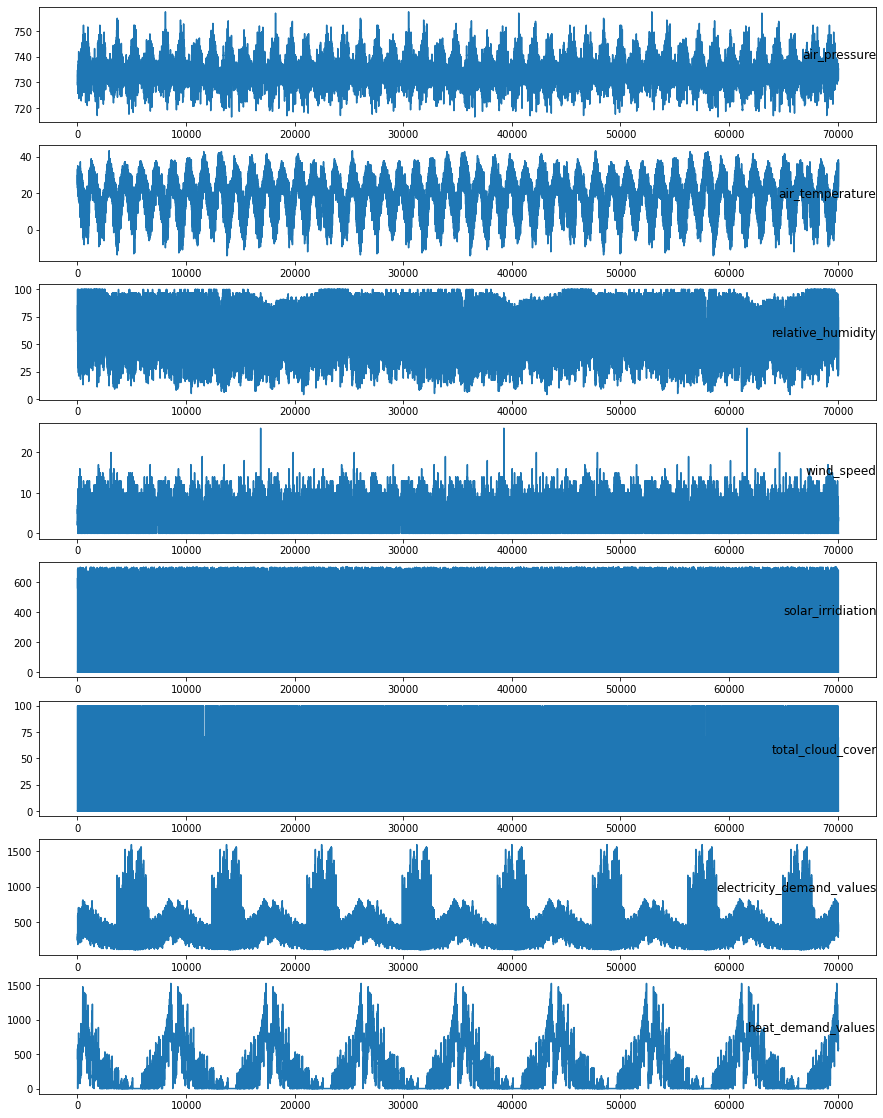

In [159]:
data3 = pd.read_csv('electricity_consumption.csv',header=0,index_col=0)
values = data3.values
groups = [0,1,2,3,4,5,6,7]
# plot each column
i = 1
plt.figure(figsize=(15,20))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(data3.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [160]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

#apply adf test on the series
ad_fuller_test = {}
for col in data3:
    ad_fuller_test[col] =  adf_test(data3[col][:10000])    

In [161]:
for k in ad_fuller_test:
    print(k)
    print(ad_fuller_test[k])
    print("-----------")

air_pressure
Test Statistic                -1.083193e+01
p-value                        1.699465e-19
#Lags Used                     3.800000e+01
Number of Observations Used    9.961000e+03
Critical Value (1%)           -3.431007e+00
Critical Value (5%)           -2.861830e+00
Critical Value (10%)          -2.566924e+00
dtype: float64
-----------
air_temperature
Test Statistic                   -4.066939
p-value                           0.001098
#Lags Used                       38.000000
Number of Observations Used    9961.000000
Critical Value (1%)              -3.431007
Critical Value (5%)              -2.861830
Critical Value (10%)             -2.566924
dtype: float64
-----------
relative_humidity
Test Statistic                -1.185549e+01
p-value                        7.044324e-22
#Lags Used                     3.300000e+01
Number of Observations Used    9.966000e+03
Critical Value (1%)           -3.431006e+00
Critical Value (5%)           -2.861830e+00
Critical Value (10%)      

series is stationary

### Step 4 Data Prepration

In [162]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [163]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

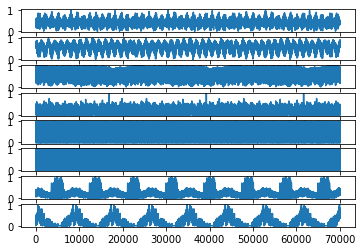

In [164]:
values = values.astype('float32')
#Normalization of data
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
groups = [0,1,2,3,4,5,6,7]
i = 1
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(scaled[:, group])
	i += 1
plt.show()

In [165]:
# conver to supervised learning frame with previous time step measurements
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.321951,0.682842,0.843750,0.192308,0.0,0.0,0.119342,0.283121,0.314634,0.731369,0.760417,0.269231,0.0,0.0,0.099477,0.309930
2,0.314634,0.731369,0.760417,0.269231,0.0,0.0,0.099477,0.309930,0.302441,0.826690,0.604167,0.269231,0.0,0.2,0.090764,0.316040
3,0.302441,0.826690,0.604167,0.269231,0.0,0.2,0.090764,0.316040,0.368292,0.807626,0.604167,0.076923,0.0,0.5,0.097982,0.357005
4,0.368292,0.807626,0.604167,0.076923,0.0,0.5,0.097982,0.357005,0.392683,0.644714,0.958333,0.115385,0.0,0.2,0.098184,0.360017
5,0.392683,0.644714,0.958333,0.115385,0.0,0.2,0.098184,0.360017,0.392683,0.672444,0.968750,0.115385,0.0,0.0,0.111240,0.376821


In [166]:
reframed.drop(reframed.columns[[8,9,10,11,12,13,15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var7(t)
1,0.321951,0.682842,0.843750,0.192308,0.0,0.0,0.119342,0.283121,0.099477
2,0.314634,0.731369,0.760417,0.269231,0.0,0.0,0.099477,0.309930,0.090764
3,0.302441,0.826690,0.604167,0.269231,0.0,0.2,0.090764,0.316040,0.097982
4,0.368292,0.807626,0.604167,0.076923,0.0,0.5,0.097982,0.357005,0.098184
5,0.392683,0.644714,0.958333,0.115385,0.0,0.2,0.098184,0.360017,0.111240


### STEP 5 Test Train Spliting

In [178]:
values = reframed.values
n_train_hours = 365 * 24 *5
X = values[:,:-1]
Y = values[:,-1]
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))




In [179]:
train_X.shape

(43800, 1, 8)

In [180]:
train_y.shape

(43800,)

In [181]:
# # design network
# model = Sequential()
# model.add(LSTM(units= 50, return_sequences = True,input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))
# model.add(Dense(1))


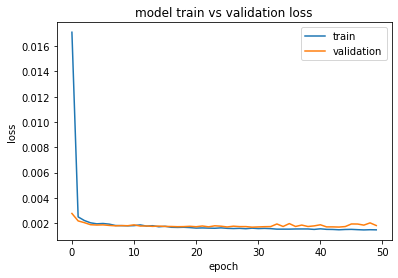

822/822 [==============================] - 3s 4ms/step - loss: 0.0022
['loss']
0.002172930398955941
Test RMSE: 1.911


In [182]:

model = Sequential()
model.add(LSTM(units = 128, return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.3))
model.add(LSTM(units = 128, return_sequences = True))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.3))
model.add(LSTM(units = 64, return_sequences = False))
model.add(Dropout(0.3))
model.add(Dense(units = 1))

# early_stoping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,mode='min')
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, verbose=0, shuffle=False,validation_split=0.33,batch_size=75)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

score = model.evaluate(test_X,test_y)
print(model.metrics_names)
print(score)


yhat = model.predict(test_X)


test_X_copy = test_X.copy()
yhat = yhat.reshape(yhat.shape[0],yhat.shape[1])
test_X_copy = test_X_copy.reshape(test_X_copy.shape[0],test_X_copy.shape[2])
#inverse scaling for forcast
inv_yhat = concatenate((yhat, test_X_copy[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0] 

# invert scaling for actual
test_y_copy = test_y.copy()
test_y_copy = test_y_copy.reshape((len(test_y_copy), 1))
inv_y = concatenate((test_y_copy, test_X_copy[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
mse = mean_squared_error(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)

In [172]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 1, 128)            70144     
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 1, 128)            0         
                                                                 
 dropout_12 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_13 (LSTM)              (None, 1, 128)            131584    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 1, 128)            0         
                                                                 
 dropout_13 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_14 (LSTM)              (None, 64)               

In [173]:
from sklearn.metrics import r2_score
r2_score(inv_y,inv_yhat)

0.9279589035852471

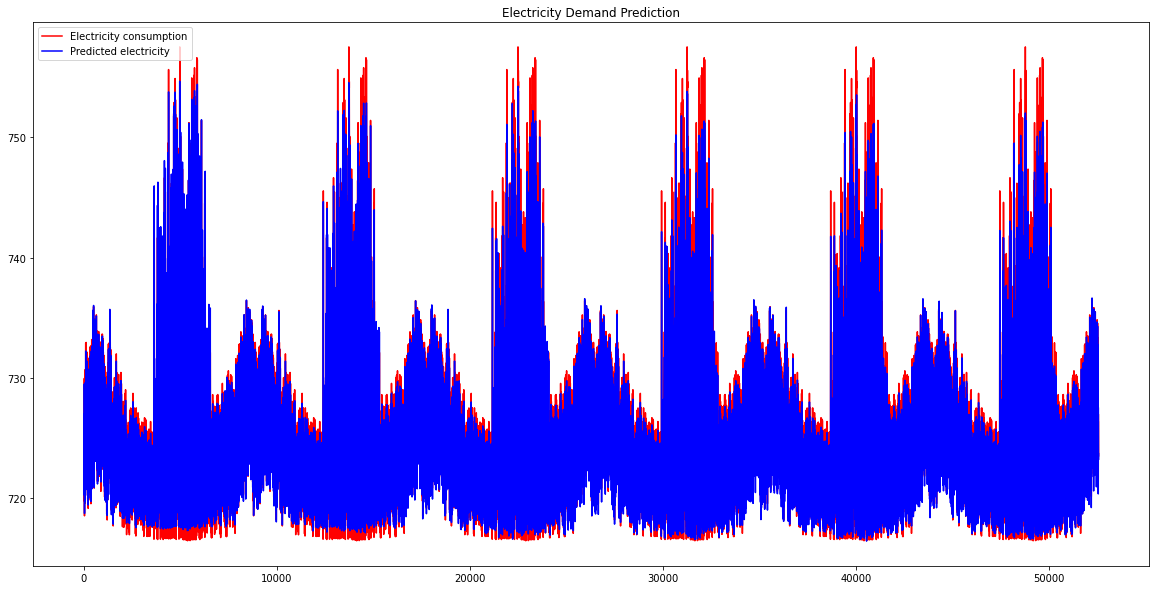

In [174]:
plt.figure(figsize=(20,10))
plt.plot(inv_y, color = 'red', label = 'Electricity consumption')
plt.plot(inv_yhat, color = 'blue', label = 'Predicted electricity')
plt.title('Electricity Demand Prediction')
plt.legend()
plt.show()

In [175]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14196035035000679840
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4158062592
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5583701277271366379
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]
